<Axes: xlabel='Month'>

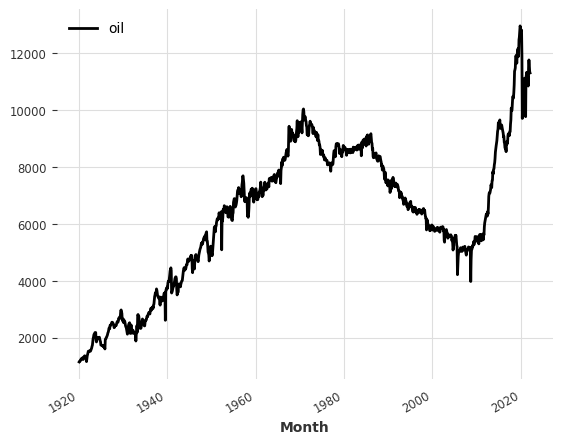

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('crudeOil.csv', index_col= 'Month').rename(columns= {'Oil_tbpd' : 'oil'})
df.index = pd.to_datetime(df.index, format = '%m-%Y')

from darts import TimeSeries
df = TimeSeries.from_dataframe(df)
df.plot()

<Axes: xlabel='Month'>

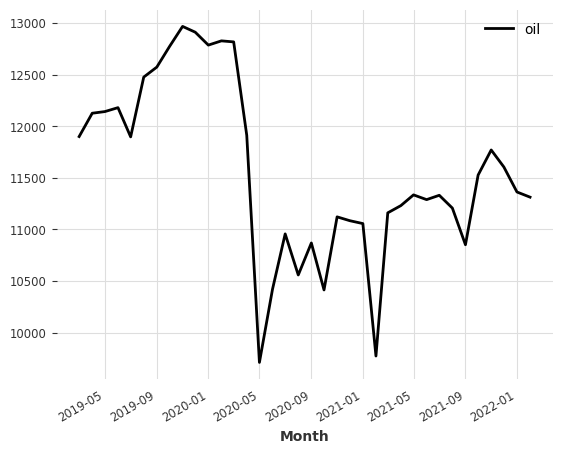

In [2]:
df[-36:].plot()